In [42]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt

In [43]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
psz2 = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv')

In [44]:
def make_histogram(ax, tp, fp, n_bins, label1='Yes matches', label2='No matches'):
    ax.hist(tp, n_bins, color='r', log=True, histtype='step', label=label1)
    ax.hist(fp, n_bins, color='b', log=True, histtype='step', label=label2)
    ax.legend()

In [45]:
df_sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
psz2_sc = SkyCoord(ra=np.array(psz2['RA'])*u.degree, dec=np.array(psz2['DEC'])*u.degree, frame='icrs')

In [46]:
idx, d2d, _ = df_sc.match_to_catalog_sky(psz2_sc)

In [47]:
red = d2d.degree < (400/3600)
#psz2 = psz2.iloc[idx[np.logical_not(red)]]
psz2_sc = SkyCoord(ra=np.array(psz2['RA'][np.logical_not(red)])*u.degree, dec=np.array(psz2['DEC'][np.logical_not(red)])*u.degree, frame='icrs')
idx, d2d, _ = df_sc.match_to_catalog_sky(psz2_sc)
violet = d2d.degree < (400/3600)
blue = np.logical_and(d2d.degree >= 400/3600, d2d.degree <1500/3600)

IndexError: Boolean index has wrong length: 23352 instead of 1653

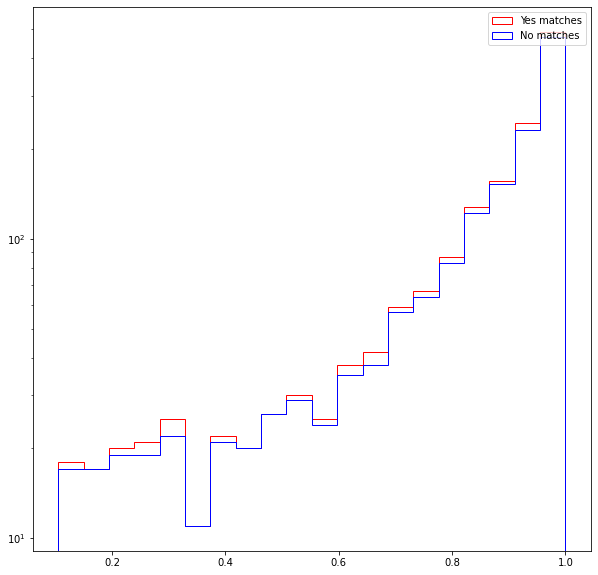

In [48]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
make_histogram(ax, df['max_pred'][red], df['max_pred'][violet], n_bins=20)

In [49]:
np.count_nonzero(red)

1545

In [50]:
len(psz2)

1653